In [30]:
# VGG 합성곱 기반 층 만들기

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))



In [31]:
conv_base.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [32]:
# 사전 훈련된 합성곱 기반 층을 사용한 특성 추출

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255.0)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size = batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i+=1
        if i * batch_size >= sample_count : 
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_test_labels = extract_features(test_dir, 1000)


train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4 * 4* 512))
test_features = np.reshape(test_features, (1000, 4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
# 완전 연결 분류기 정의 및 훈련
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu',
                      input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
            loss = 'binary_crossentropy',
             metrics = ['acc'])

log = model.fit(train_features, train_labels,
               epochs = 30,
               batch_size = 20,
               validation_data = (validation_features, validation_labels))


Epoch 1/30
100/100 [==============================] - 3s 24ms/step - loss: 0.6879 - acc: 0.5850 - val_loss: 0.4401 - val_acc: 0.8430
Epoch 2/30
100/100 [==============================] - 2s 22ms/step - loss: 0.4285 - acc: 0.8228 - val_loss: 0.3598 - val_acc: 0.8560s - loss: 0.43
Epoch 3/30
100/100 [==============================] - 2s 22ms/step - loss: 0.3583 - acc: 0.8539 - val_loss: 0.3327 - val_acc: 0.8520
Epoch 4/30
100/100 [==============================] - 2s 24ms/step - loss: 0.3220 - acc: 0.8733 - val_loss: 0.2994 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2854 - acc: 0.8906 - val_loss: 0.2817 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2718 - acc: 0.8776 - val_loss: 0.2768 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2342 - acc: 0.9081 - val_loss: 0.2648 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 2

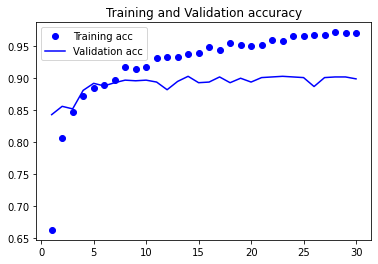

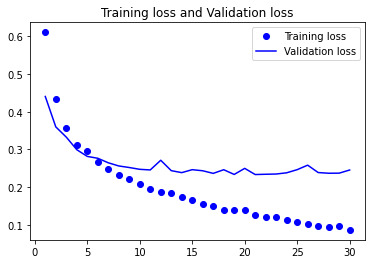

In [34]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = log.history['acc']
val_acc = log.history['val_acc']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training loss and Validation loss')
plt.legend()

plt.show()

In [35]:
#  데이터 증식을 사용한 특성 추출

In [36]:
# 합성곱 기반 층 위에 완전 연결 분류기 추가

from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [37]:
# trainable 속성을 False로 설정해 네트워크 동결

print('conv_base 동결 전 훈련 가중치 수 : ', len(model.trainable_weights))
conv_base.trainable= False
print('conv_base 동결 후 훈련 가중치 수 : ', len(model.trainable_weights))

conv_base 동결 전 훈련 가중치 수 :  30
conv_base 동결 후 훈련 가중치 수 :  4


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 183s - loss: 0.5418 - acc: 0.7395 - val_loss: 0.4143 - val_acc: 0.8490
Epoch 2/30
100/100 - 185s - loss: 0.4087 - acc: 0.8325 - val_loss: 0.3479 - val_acc: 0.8640
Epoch 3/30


KeyboardInterrupt: 

In [ ]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = log.history['acc']
val_acc = log.history['val_acc']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training loss and Validation loss')
plt.legend()

plt.show()

In [ ]:
conv_base.summary()

In [ ]:
# 특정 층까지 모든 층 동결하기

conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# 모델 미세 조정하기

model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

log = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data = validation_generator,
    validation_steps=50
)

model.save('cats_and_dogs_small_4.h5')

In [ ]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = log.history['acc']
val_acc = log.history['val_acc']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training loss and Validation loss')
plt.legend()

plt.show()


In [ ]:
#  부드러운 그래프 그리기

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label = 'Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label = 'Smoothed validation acc')
plt.title('Trining and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label = 'Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label = 'Smoothed validation loss')
plt.title('Trining and validation loss')
plt.legend()

plt.show()


In [ ]:
# 모델 평가

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode = 'binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc : ', test_acc)

